In [1]:
#NBVAL_SKIP
import matplotlib.pyplot as plt
from rubix.core.pipeline import RubixPipeline 
import os
config = {
    "pipeline":{"name": "calc_ifu"},
    
    "logger": {
        "log_level": "DEBUG",
        "log_file_path": None,
        "format": "%(asctime)s - %(name)s - %(levelname)s - %(message)s",
    },
    "data": {
        "name": "IllustrisAPI",
        "args": {
            "api_key": os.environ.get("ILLUSTRIS_API_KEY"),
            "particle_type": ["stars"],
            "simulation": "TNG50-1",
            "snapshot": 99,
            "save_data_path": "data",
        },
        
        "load_galaxy_args": {
        "id": 12,
        "reuse": True,
        },
        
        #"subset": {
        #    "use_subset": True,
        #    "subset_size": 649384,
        #},
    },
    "simulation": {
        "name": "IllustrisTNG",
        "args": {
            "path": "data/galaxy-id-12.hdf5",
        },
    
    },
    "output_path": "output",

    "telescope":
        {"name": "MUSE",
         "psf": {"name": "gaussian", "size": 5, "sigma": 0.6},
         "lsf": {"sigma": 0.5},
         "noise": {"signal_to_noise": 1,"noise_distribution": "normal"},},
    "cosmology":
        {"name": "PLANCK15"},
        
    "galaxy":
        {"dist_z": 0.1,
         "rotation": {"type": "edge-on"},
        },
        
    "ssp": {
        "template": {
            "name": "BruzualCharlot2003"
        },
    },        
}

pipe = RubixPipeline(config)

data= pipe.run()

#datacube = data.stars.datacube
#img = datacube.sum(axis=2)
#plt.imshow(img, origin="lower")

2024-07-17 11:30:00,507 - rubix - INFO - 
   ___  __  _____  _____  __
  / _ \/ / / / _ )/  _/ |/_/
 / , _/ /_/ / _  |/ /_>  <  
/_/|_|\____/____/___/_/|_|  
                            

2024-07-17 11:30:00,509 - rubix - INFO - Rubix version: 0.0.post68+g83b3a1f.d20240716
2024-07-17 11:30:00,510 - rubix - WARNING - python-fsps is not installed. Please install it to use this function. Install using pip install fsps and check the installation page: https://dfm.io/python-fsps/current/installation/ for more details. Especially, make sure to set all necessary environment variables.
/home/annalena/rubix/rubix/telescope/factory.py:21: UserWarning: No telescope config provided, using default stored in /home/annalena/rubix/rubix/telescope/telescopes.yaml
  warnings.warn(
2024-07-17 11:30:01,640 - rubix - INFO - Getting rubix data...
2024-07-17 11:30:01,642 - rubix - INFO - Rubix galaxy file already exists, skipping conversion


{'pipeline': {'name': 'calc_ifu'}, 'logger': {'log_level': 'DEBUG', 'log_file_path': None, 'format': '%(asctime)s - %(name)s - %(levelname)s - %(message)s'}, 'data': {'name': 'IllustrisAPI', 'args': {'api_key': '05add2d69d501eb62014faa4dadb1af0', 'particle_type': ['stars'], 'simulation': 'TNG50-1', 'snapshot': 99, 'save_data_path': 'data'}, 'load_galaxy_args': {'id': 12, 'reuse': True}}, 'simulation': {'name': 'IllustrisTNG', 'args': {'path': 'data/galaxy-id-12.hdf5'}}, 'output_path': 'output', 'telescope': {'name': 'MUSE', 'psf': {'name': 'gaussian', 'size': 5, 'sigma': 0.6}, 'lsf': {'sigma': 0.5}, 'noise': {'signal_to_noise': 1, 'noise_distribution': 'normal'}}, 'cosmology': {'name': 'PLANCK15'}, 'galaxy': {'dist_z': 0.1, 'rotation': {'type': 'edge-on'}}, 'ssp': {'template': {'name': 'BruzualCharlot2003'}}}


2024-07-17 11:30:03,476 - rubix - INFO - Data loaded with 649384 star particles and 0 gas particles.
2024-07-17 11:30:03,478 - rubix - INFO - Data loaded with 48 properties.
2024-07-17 11:30:03,478 - rubix - DEBUG - Data: RubixData(galaxy=Galaxy(redshift=2.220446049250313e-16, center=array([11413.86337268, 35893.86374042, 32027.01940138]), halfmassrad_stars=7.727193253526112), stars=StarsData(coords=Array([[ 1.1718750e-02, -5.4687500e-02, -1.3671875e-02],
       [-2.9296875e-03, -6.2500000e-02, -1.1718750e-02],
       [ 6.8359375e-03, -7.8125000e-02, -3.9062500e-03],
       ...,
       [-1.6905273e+01,  4.7035156e+01, -1.7578125e+00],
       [-4.8350586e+01,  3.6402344e+01, -1.5941406e+01],
       [-5.8808594e+00,  5.5078125e+00,  3.5298828e+01]], dtype=float32), velocity=Array([[ 1.8367677e-16, -4.7929042e-17,  7.4227191e-17],
       [ 2.1569694e-18,  3.0625969e-16,  1.5955390e-16],
       [ 1.8713838e-16,  1.7605305e-16,  6.9643049e-17],
       ...,
       [ 3.0933031e-15, -4.6513599

In [2]:
import jax.numpy as jnp
print(data.stars.pixel_assignment)
print(data.stars.spatial_bin_edges)
print(data.stars.spectra.shape)

sum_spectra = jnp.sum(data.stars.spectra, axis=1)
print(sum_spectra.shape)
print(sum_spectra)
#indices_nonzero = jnp.where(data.stars.spectra[0][:][100] != 0)
#print(indices_nonzero)

#spectra_np = jnp.array(data.stars.spectra)

# Set NumPy print options
#jnp.set_printoptions(threshold=60000)

# Print the full array
#print(spectra_np)

[[312 312 312 ... 624 454 600]]
[[-4.7619     -4.380948   -3.9999962  -3.6190443  -3.2380924  -2.8571405
  -2.4761887  -2.0952368  -1.7142849  -1.333333   -0.95238113 -0.57142925
  -0.19047737  0.19047451  0.5714264   0.9523783   1.3333302   1.714282
   2.095234    2.4761858   2.8571377   3.2380896   3.6190414   3.9999933
   4.380945    4.761897  ]]
(1, 649384, 3721)
(1, 3721)
[[1.9819494e+08 1.9806506e+08 1.9793517e+08 ... 2.1567288e+07
  2.1523986e+07 2.1480680e+07]]


In [3]:
def print_object_attributes(obj):
    # Filter out magic methods and print attribute names and their values
    for attr in dir(obj):
        if not attr.startswith('__'):
            print(f"{attr}")#: {getattr(obj, attr)}")

# Assuming `data` is your object
print_object_attributes(data.stars)
print(data.stars.mask)


age
coords
datacube
mask
mass
metallicity
pixel_assignment
spatial_bin_edges
spectra
tree_flatten
tree_unflatten
velocity
[[ True  True  True ... False  True False]]


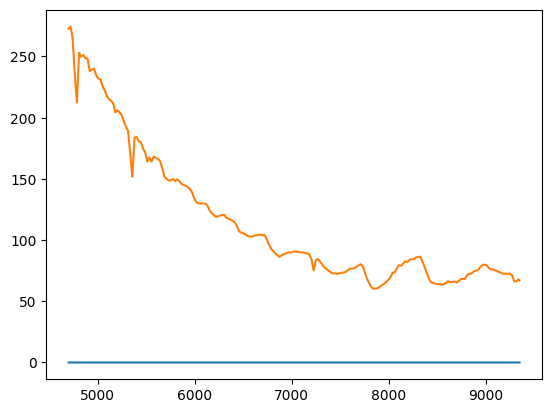

In [4]:
#NBVAL_SKIP
wave = pipe.telescope.wave_seq
plt.plot(wave, data.stars.spectra[0][0][:])
plt.plot(wave, data.stars.spectra[0][1][:])


Some of the spectra may be zero, this happens if the metallicity or age values are outside the range of the SSP model. This is currently the expected behavior

In [5]:
#NBVAL_SKIP
import jax 
import jax.numpy as jnp
# Create a function to calculate a single IFU cube
def calculate_ifu_cube(stars_spectra, pixel_indices):
    # Create an IFU cube of shape (25*25, 842)
    #ifu_cube = jnp.zeros((25 * 25, 842))
    
    # Use jax.ops.segment_sum to sum the spectra into the IFU cube based on pixel indices
    ifu_cube = jax.ops.segment_sum(stars_spectra, pixel_indices, num_segments=25*25)
    
    # Reshape the IFU cube to the desired shape (25, 25, 842)
    ifu_cube = ifu_cube.reshape((25, 25, 3721))
    
    return ifu_cube

spectra = data.stars.spectra
assignments = data.stars.pixel_assignment

# Calculate 4 individual IFU cubes
ifu_cubes = jax.vmap(calculate_ifu_cube)(spectra, assignments)

# Sum the 4 IFU cubes
final_ifu_cube = jnp.sum(ifu_cubes, axis=0)
final_ifu_cube.shape

(25, 25, 3721)

In [6]:
#NBVAL_SKIP
wavelengths = pipe.telescope.wave_seq

# get the indices of the visible wavelengths of 4000-8000 Angstroms

visible_indices = jnp.where((wavelengths >= 4000) & (wavelengths <= 8000))



In [7]:
#NBVAL_SKIP
wavelengths

Array([4700.15, 4701.4 , 4702.65, ..., 9347.65, 9348.9 , 9350.15],      dtype=float32)

In [8]:
#NBVAL_SKIP
spectra[0,7]

Array([0., 0., 0., ..., 0., 0., 0.], dtype=float32)

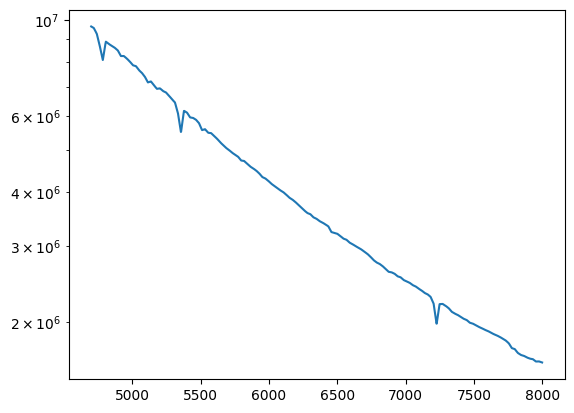

In [9]:
#NBVAL_SKIP
# plot example spectrum
import matplotlib.pyplot as plt

spec = final_ifu_cube[12, 12]

plt.plot(wavelengths[visible_indices], spec[visible_indices])
plt.yscale("log")

In [10]:
#NBVAL_SKIP
# get the spectra of the visible wavelengths from the ifu cube
visible_spectra = final_ifu_cube[:, :, visible_indices[0]]
visible_spectra.shape

(25, 25, 2640)

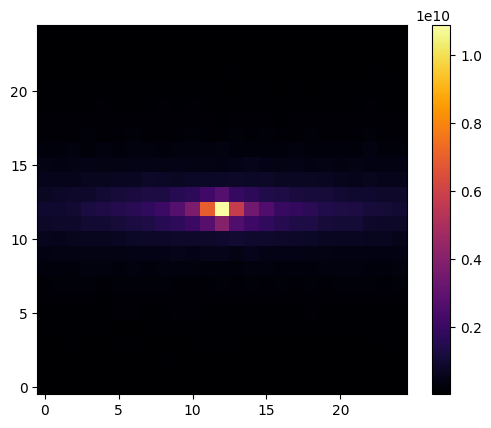

In [11]:
#NBVAL_SKIP
# Sum up all spectra to create an image
image = jnp.sum(visible_spectra, axis = 2)
plt.imshow(image, origin="lower", cmap="inferno")
plt.colorbar()